In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas  1.0.4
numpy   1.18.4
seaborn 0.10.1



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import shap

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5037974/
inf_truth = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/mbarc_26_truth.txt"
inf_tax_file = "/mnt/btrfs/data/rep202/ab/taxmap.tsv"
outf_truth = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/mbarc_26_truth_rg.txt"

inf_type_1_coverage = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/filter/features_test.csv"
inf_shogun_coverage = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/filter/coverage-201029.txt"


# bmock12
bmock12_inf_truth = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/bmock_12/SRR8073716/bmock_12_truth.txt"
bmock12_inf_tax_file = "/mnt/btrfs/data/rep202/ab/taxmap.tsv"
bmock12_outf_truth = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/bmock_12/SRR8073716/bmock_12_truth_rg.txt"

bmock12_inf_coverage = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/bmock_12/SRR8073716/coverage-201029.txt"

# Building the true species dataset

In [4]:
with open(outf_truth, "w") as outf:
    with open(inf_truth) as inf:
        for query in inf:
            query = query.rstrip()
            print(query)
            results = !rg {query} {inf_tax_file}
            for result in results:
                outf.write(result + "\n")

Escherichia_coli
Salmonella_enterica
Salmonella_bongori
Pseudomonas_stutzeri
Hirschia_baltica
Frateuria_aurantia
Streptococcus_pyogenes
Thermobacillus_composti
Desulfosporosinus_meridiei
Desulfosporosinus_acidiphilus
Desulfallas_gibsoniae
Hungateiclostridium_thermocellum
Clostridium_perfringens
Corynebacterium_glutamicum
Segniliparus_rotundus
Nocardiopsis_dassonvillei
Olsenella_uli
Coraliomargarita_akajimensis
Terriglobus_roseus
Meiothermus_silvanus
Echinicola_vietnamensis
Sediminispirochaeta_smaragdinae
Fervidobacterium_pennivorans
Halovivax_ruber
Natronobacterium_gregoryi
Natronococcus_occultus


In [5]:
df_tax = pd.read_csv(inf_tax_file, names=["assembly_accession", "tax"], sep="\t")

df_tax["species"] = [_.split(";")[6] for _ in df_tax.tax]
df_tax["genus"] = [_.split(";")[5] for _ in df_tax.tax]
df_tax["family"] = [_.split(";")[4] for _ in df_tax.tax]

In [6]:
df_type_1_features = pd.read_csv(inf_type_1_coverage, index_col=0)

df_type_1_features = pd.merge(df_type_1_features, df_tax, how="left", on="assembly_accession")

df_shogun_features = pd.read_csv(inf_shogun_coverage, sep="\t")
headers = list(df_shogun_features.columns)
headers[0] = "tax"
df_shogun_features.columns = headers

In [7]:
df_truth = pd.read_csv(outf_truth, header=None, sep="\t", names=["assembly_accession", "tax"])
s_truth = set(df_truth["assembly_accession"])

df_type_1_features["truth"] = [_ in s_truth for _ in df_type_1_features.assembly_accession]

In [8]:
df_type_1_features.groupby("truth").max()

,assembly_accession,hits,percent_coverage,expected_coverage,percent_padded_coverage,shannon_entropy,percent_max_uncovered_region,largest_pileup,gc_content,genome_length,num_n_groups,consecutive_ns,tax,species,genus,family
truth,,,,,,,,,,,,,,,,
False,GCF_903652925.1,605899,inf,1.0,1.326339e+12,2.171620,2.000000,25789,0.770192,13613686,2033,4435411,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,s__[Ruminococcus]_torques,g__Zymobacter,f__Zoogloeaceae
True,GCF_900638035.1,17825608,3.886471e+10,1.0,1.470382e+10,6.259692,0.404189,37882,0.726158,6641645,31,100,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,s__Thermobacillus_composti,g__Thermobacillus,f__Thermaceae


In [9]:
df_type_1_features

,assembly_accession,hits,percent_coverage,expected_coverage,percent_padded_coverage,shannon_entropy,percent_max_uncovered_region,largest_pileup,gc_content,genome_length,num_n_groups,consecutive_ns,tax,species,genus,family,truth
0,GCF_000233715.2,5850498,4.855530e+06,1.000000,4.855557e+06,NaN,2.059508e-07,2668,0.454910,4855529,0,0,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,s__Desulfallas_gibsoniae,g__Desulfallas,f__Peptococcaceae,True
1,GCF_000227705.2,5884236,4.357000e+06,1.000000,4.356534e+06,NaN,5.579121e-05,4756,0.601164,4355525,1,20,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,s__Thermobacillus_composti,g__Thermobacillus,f__Paenibacillaceae,True
2,GCF_000025905.1,2219355,3.750772e+06,1.000000,3.750812e+06,NaN,2.666119e-07,678,0.536018,3750771,0,0,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,s__Coraliomargarita_akajimensis,g__Coraliomargarita,f__Puniceicoccaceae,True
3,GCF_000017545.1,605899,9.987303e+07,1.000000,9.037285e+07,NaN,2.383700e-01,25789,0.349893,1948941,0,0,k__Bacteria;p__Thermotogae;c__Thermotogae;o__T...,s__Fervidobacterium_nodosum,g__Fervidobacterium,f__Fervidobacteriaceae,False
4,GCF_001644665.1,2083245,8.145842e+06,1.000000,7.186443e+06,NaN,1.817104e-02,25789,0.389368,2061852,0,0,k__Bacteria;p__Thermotogae;c__Thermotogae;o__T...,s__Fervidobacterium_pennivorans,g__Fervidobacterium,f__Fervidobacteriaceae,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7354,GCF_003386675.1,1,1.985298e+11,0.000018,6.452220e+10,0.000311,9.999819e-01,1,0.700075,3592275,9,96,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,s__Microbacterium_chocolatum,g__Microbacterium,f__Microbacteriaceae,False
7355,GCF_900097955.1,1,1.101172e+11,0.000024,3.578810e+10,0.000407,9.999757e-01,1,0.324814,2675373,35,362,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,s__Staphylococcus_cohnii,g__Staphylococcus,f__Staphylococcaceae,False
7356,GCF_900103135.1,1,1.231825e+11,0.000022,3.695475e+10,0.000373,9.999779e-01,1,0.450703,2718630,71,20,k__Bacteria;p__Firmicutes;c__Clostridia;o__Hal...,s__Halarsenatibacter_silvermanii,g__Halarsenatibacter,f__Halanaerobiaceae,False
7357,GCF_000219125.1,1,3.114687e+11,0.000014,9.344061e+10,0.000244,9.999861e-01,1,0.503612,4322976,297,20,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,s__Acetonema_longum,g__Acetonema,f__Sporomusaceae,False


In [10]:
df_type_1_features = df_type_1_features.replace([np.inf, -np.inf], np.nan)
df_type_1_features = df_type_1_features.dropna()

X_type_1 = df_type_1_features.loc[:, df_type_1_features.columns.difference(["assembly_accession", "tax", "truth", "species", "family", "genus"])]

y = df_type_1_features["truth"]
X_type_1_train, X_type_1_test, y_train, y_test = train_test_split(X_type_1, y, random_state=42)

In [11]:
clf = RandomForestClassifier(random_state=42)

clf.fit(X_type_1_train, y_train)

RandomForestClassifier(random_state=42)

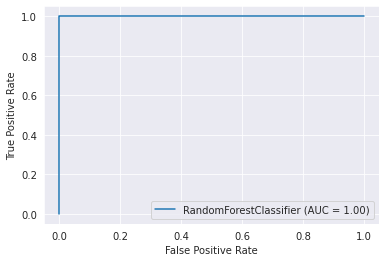

In [12]:
clf_disp = plot_roc_curve(clf, X_type_1_test, y_test)
plt.show()

In [13]:
# X_type_1["truth"] = y
# sns.pairplot(X_type_1, hue="truth")

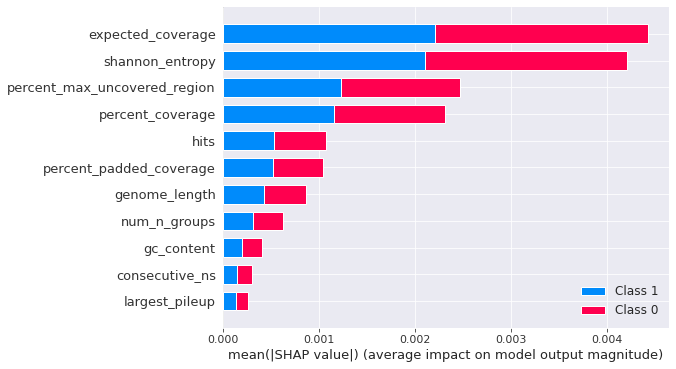

In [14]:
explainer = shap.TreeExplainer(clf, X_type_1_train)

shap_values = explainer.shap_values(X_type_1_train)
shap.summary_plot(shap_values, X_type_1_train, show=False)
fig = plt.gcf()

In [15]:
df_truth.columns = ["id", "tax"]
df_truth["species"] = [";".join(s.split(";")[:7]) for s in df_truth["tax"]]
s_truth = set(df_truth["species"])

df_shogun_features["truth"] = [species in s_truth for species in df_shogun_features.tax]

In [16]:
X = df_shogun_features.loc[:, df_shogun_features.columns.difference(["truth", "tax", "ratio_covered_over_expected", "species"])]
y = df_shogun_features["truth"]
X_shogun_train, X_shogun_test, y_shogun_train, y_shogun_test = train_test_split(X, y, random_state=42)

In [17]:
clf_shogun = RandomForestClassifier(random_state=42)

clf_shogun.fit(X_shogun_train, y_shogun_train)

RandomForestClassifier(random_state=42)

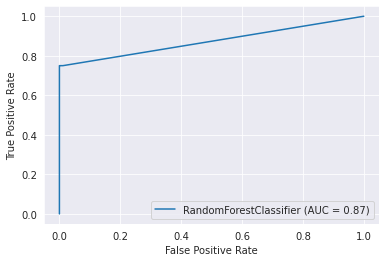

In [18]:
clf_shogun_disp = plot_roc_curve(clf_shogun, X_shogun_test, y_shogun_test)
plt.show()

In [143]:
y_mbarc26_preds = clf_shogun.predict(X)

accuracy_mbarc26_shogun = (y_mbarc26_preds == y).sum() / (y.shape[0])

print(accuracy_mbarc26_shogun)

0.9998640195811803


In [145]:
y_mbarc26_preds.sum()

25

In [119]:
mbarc26_capitalist_inf = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/filter/taxatable.capitalist.species.txt"
mbarc26_shogun_inf = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/filter/taxatable.species.txt"

In [139]:
df_mbarc26_capitalist = pd.read_csv(mbarc26_capitalist_inf, sep="\t")
df_mbarc26_shogun = pd.read_csv(mbarc26_shogun_inf, sep="\t")

In [140]:
df_mbarc26_capitalist["species"] = [";".join(_.split(";")[:7]) for _ in df_mbarc26_capitalist["#OTU ID"]]
df_mbarc26_capitalist["truth"] = [species in s_truth for species in df_mbarc26_capitalist.species]

accuracy_mbarc26 = df_mbarc26_capitalist["truth"].sum() / df_mbarc26_capitalist["truth"].shape[0]
print(accuracy_mbarc26)

0.017310252996005325


In [141]:
df_mbarc26_capitalist["species"] = [";".join(_.split(";")[:7]) for _ in df_mbarc26_capitalist["#OTU ID"]]
df_mbarc26_capitalist["truth"] = [species in s_truth for species in df_mbarc26_capitalist.species]

df_mbarc26_capitalist["SRR3656745"] = df_mbarc26_capitalist["SRR3656745"] / df_mbarc26_capitalist["SRR3656745"].sum()

df_mbarc26_capitalist = df_mbarc26_capitalist[df_mbarc26_capitalist["SRR3656745"] > .005]

accuracy_mbarc26 = df_mbarc26_capitalist["truth"].sum() / df_mbarc26_capitalist.shape[0]

In [142]:
df_mbarc26_capitalist["species"]

10     k__Archaea;p__Euryarchaeota;c__Halobacteria;o_...
13     k__Archaea;p__Euryarchaeota;c__Halobacteria;o_...
16     k__Archaea;p__Euryarchaeota;c__Halobacteria;o_...
62     k__Bacteria;p__Actinobacteria;c__Actinobacteri...
87     k__Bacteria;p__Actinobacteria;c__Coriobacterii...
107    k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__...
139    k__Bacteria;p__Deinococcus-Thermus;c__Deinococ...
172    k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
236    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
264    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
270    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
273    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
343    k__Bacteria;p__Proteobacteria;c__Alphaproteoba...
712    k__Bacteria;p__Proteobacteria;c__Gammaproteoba...
734    k__Bacteria;p__Spirochaetes;c__Spirochaetia;o_...
746    k__Bacteria;p__Thermotogae;c__Thermotogae;o__T...
750    k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...
Name: species, dtype: object

# bmock12 test

In [52]:
with open(bmock12_outf_truth, "w") as outf:
    with open(bmock12_inf_truth) as inf:
        for query in inf:
            query = query.rstrip()
            results = !rg {query} {inf_tax_file}
            for result in results:
                outf.write(result + "\n")

In [53]:
df_bmock12_inf_coverage = pd.read_csv(bmock12_inf_coverage, sep="\t")
headers = list(df_bmock12_inf_coverage.columns)
headers[0] = "tax"
df_bmock12_inf_coverage.columns = headers

In [54]:
df_bmock12_truth.dtypes

id     object
tax    object
dtype: object

In [57]:
df_bmock12_truth = pd.read_csv(bmock12_outf_truth, header=None, sep="\t")

df_bmock12_truth.columns = ["id", "tax"]
df_bmock12_truth["species"] = [";".join(s.split(";")[:7]) for s in df_bmock12_truth["tax"]]
s_truth = set(df_bmock12_truth["species"])
df_bmock12_inf_coverage["truth"] = [species in s_truth for species in df_bmock12_inf_coverage.tax]
df_bmock12_inf_coverage["truth"].sum()
len(s_truth)

225

In [62]:
X_bmock12 = df_bmock12_inf_coverage.loc[:, df_bmock12_inf_coverage.columns.difference(["truth", "tax", "ratio_covered_over_expected", "species"])]
y_bmock12 = df_bmock12_inf_coverage["truth"]

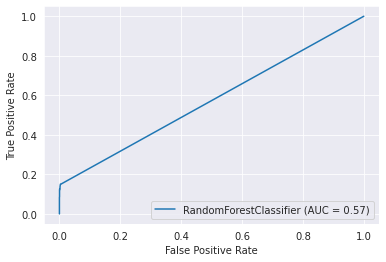

In [65]:
y_bmock12_preds = clf_shogun.predict(X_bmock12)

lgb_disp = plot_roc_curve(clf_shogun, X_bmock12, y_bmock12)
plt.show()

In [69]:
accuracy_bmock12_shogun = (y_bmock12_preds == y_bmock12).sum() / (y_bmock12.shape[0])

In [77]:
bmock12_capitalist_inf = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/bmock_12/SRR8073716/filter/results-201029/taxatable.capitalist.species.txt"
bmock12_shogun_inf = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/bmock_12/SRR8073716/filter/results-201029/taxatable.species.txt"

In [108]:
df_bmock12_capitalist = pd.read_csv(bmock12_capitalist_inf, sep="\t")
df_bmock12_shogun = pd.read_csv(bmock12_shogun_inf, sep="\t")

In [109]:
df_bmock12_shogun["species"] = [";".join(_.split(";")[:7]) for _ in df_bmock12_shogun["#OTU ID"]]
df_bmock12_shogun["truth"] = [species in s_truth for species in df_bmock12_shogun.species]

accuracy_bmock12_shogun_redistribute = df_bmock12_shogun["truth"].sum() / df_bmock12_shogun.shape[0]

In [110]:
df_bmock12_capitalist["species"] = [";".join(_.split(";")[:7]) for _ in df_bmock12_capitalist["#OTU ID"]]
df_bmock12_capitalist["truth"] = [species in s_truth for species in df_bmock12_capitalist.species]

df_bmock12_capitalist["SRR8073716"] = df_bmock12_capitalist["SRR8073716"] / df_bmock12_capitalist["SRR8073716"].sum()

df_bmock12_capitalist = df_bmock12_capitalist[df_bmock12_capitalist["SRR8073716"] > .005]

accuracy_bmock12_capitalist = df_bmock12_capitalist["truth"].sum() / df_bmock12_capitalist.shape[0]

In [111]:
accuracy_bmock12_capitalist

0.9333333333333333

In [112]:
df_bmock12_capitalist

,#OTU ID,SRR8073716,species,truth
17,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.185369,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,True
18,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.220644,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,True
29,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.167796,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,True
56,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...,0.161311,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...,True
108,k__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.045901,k__Bacteria;p__Proteobacteria;c__Alphaproteoba...,True
112,k__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.029796,k__Bacteria;p__Proteobacteria;c__Alphaproteoba...,True
134,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.006230,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,True
139,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.068989,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,True
148,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.007187,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,True
174,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.006238,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,True
